In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

In [3]:
torch.cuda.is_available()

False

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable
# from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.datasets as datasets
import torchvision.utils as vutils

import numpy as np
import csv
import pandas as pd
import math
import numpy as np
import glob
import tqdm
import sys
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.image as mpimg
from tqdm import tqdm
import sklearn
from sklearn.metrics import accuracy_score

import seaborn as sns
sns.set_theme(style="ticks")

import torchvision
from torchvision.io import read_image

# from sdtw_cuda_loss import SoftDTW

In [3]:
# %load_ext tensorboard
# from torch.utils.tensorboard import SummaryWriter

In [4]:
device = torch.device('cuda:1') #  if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=1)

In [5]:
# target_folder = './extracted/mwd/nopims/'
target_folder = '/home/sharifullina/thesis/TIME/extracted/mwd/volve/'
# target_folder = '/Users/ramilasarifullina/Desktop/extracted/well_logs/volve/'
# target_folder = '/Users/ramilasarifullina/Desktop/extracted/well_logs/nopims/'

### Выгрузим датасет Volve и преобразуем данные

In [6]:
import os
import json
wells = os.listdir(target_folder)
required_params_plus = ['DEPTH', 'ROPA', 'HKLA', 'WOB', 'SPPA', 'WELL']
required_params = ['DEPTH', 'ROPA', 'HKLA', 'WOB', 'SPPA']

logs = [json.load(open(os.path.join(target_folder, wells[i]), 'r')) for i in range(len(wells))]

In [7]:
# X_all - Dataframe with all logging while drilling data concatenated

dataset_all = [pd.DataFrame(logs[i]['data'], columns=[x['name'] for x in logs[i]['curves']]) for i in range(len(logs))]
for i in range(len(dataset_all)):
    dataset_all[i]['WELL'] = wells[i]

dataset = []
for df in dataset_all:
    dataset.append(df[required_params_plus])
    
X_all = dataset[0]
for i in range(1, len(dataset)):
    X_all = pd.concat([X_all, dataset[i]], ignore_index = True)
X_all = X_all.ffill().bfill()

# X_list is a list containing a data for all wells splitted to windows with size 256

X_list = []
for i in range(0, len(X_all) - 256, 10):
    X_list.append(X_all[i : 256 + i])

    
# X_list_minus is X_list but without the WELL column
    
X_list_minus = []
for x in X_list:
    X_list_minus.append(x.loc[:, x.columns != 'WELL'])

X_verif_list = X_list_minus
    
# X is an array with the shape = (5901, 256, 5)
    
X = []
for i in X_list_minus:
    X.append(i.values)

X = np.dstack(X)
X = np.rollaxis(X, -1)

# map_well_to_label is dictionary to help to rename wells from 'well_N' to N
map_well_to_label = {w:i for i, w in enumerate(wells)}

# label = well's number
y = np.array([map_well_to_label[df['WELL'].iloc[0]] for df in X_list])


### Импортируем verificator, regulator

In [8]:
from dataset import *
from model import * # GAN model
from inceptiontime.src.models.inception import InceptionModel # Verificator
# Regulator
from time_series_metrics.ssim_loss import SSIM_1d_conv
# from time_series_metrics.tsfresh_metrics import tsfresh_metrics
from time_series_metrics.tsfresh_loss import Mean_similarity_loss, Root_mean_square_similarity_loss, Coisine_between_angles_loss, Pearson_corr_funct_loss, Eucledian_distance_loss


### Загрузим датасет

In [9]:
from dataset import *
torch_dataset = Main_dataset(X, y, sparse_rate=1)
all_loader = DataLoader(torch_dataset, batch_size=64, shuffle=True)


In [10]:
train_n = 5310
train_set, val_set = torch.utils.data.random_split(torch_dataset, [train_n, len(torch_dataset) - train_n])

In [11]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=True)

### создадим датасет для верификатора

In [12]:
# соеденим все логи скважин в один большой pandas.DaraFrame
dataset_all = [pd.DataFrame(logs[i]['data'], columns=[x['name'] for x in logs[i]['curves']]) for i in range(len(logs))]
dataset = []
for df in dataset_all:
    dataset.append(df[required_params])
X_all = dataset[0]
for i in range(1, len(dataset)):
    X_all = pd.concat([X_all, dataset[i]], ignore_index = True)
X_all = X_all.ffill().bfill()

In [13]:
similar_wells = []

for i in range(0, 18400, 20):
    similar_wells.append(X_all[i : 256 + i])
# преобразуем лист в массив с размерностью [20, 256, 5]; 20 - количество скважин, 256 - размерность окна, 
#                                                   5 - количество столбцов = len(required_params)
similar_wells = np.dstack(similar_wells)
similar_wells = np.rollaxis(similar_wells, -1)
similar_wells.shape

(920, 256, 5)

In [14]:
# different_wells = []

# for i in range(0, 256 * 230, 256):
#     different_wells.append(X_all[i : 256 + i])
#     different_wells.append(X_all[i : 256 + i] + np.random.normal(X_all[i : 256 + i].mean(),\
#                                                                  X_all[i : 256 + i].std(), [256, 5]))
#     different_wells.append(X_all[i : 256 + i] + np.random.normal(X_all[i : 256 + i].mean(), \
#                                                                  X_all[i : 256 + i].std(), [256, 5]))
#     different_wells.append(X_all[i : 256 + i] + np.random.normal(X_all[i : 256 + i].mean(),\
#                                                                  X_all[i : 256 + i].std(), [256, 5]))
    
# different_wells = np.dstack(different_wells)
# different_wells = np.rollaxis(different_wells, -1)


import random
different_wells = []

for i in range(0, 256 * 230, 256):
    different_wells.append(X_all[i : i + 256])
    different_wells.append(X_all[i : i + 256])
    different_wells.append(X_all[i : i + 256])
    different_wells.append(X_all[i : i + 256])

random.shuffle(different_wells)
different_wells = np.dstack(different_wells)
different_wells = np.rollaxis(different_wells, -1)

In [15]:
needed = []
for i in range(different_wells.shape[0]):
    needed.append([different_wells[i - 1], different_wells[i], 1])
    needed.append([similar_wells[i - 1], similar_wells[i], 0])

In [16]:
# with open('some.csv', 'w') as f:
#     writer = csv.writer(f)
#     writer.writerow(['time1', 'time2', 'relationshion'])
#     writer.writerows(needed)

In [17]:
# df = pd.read_csv('some.csv')
# df = df.sample(frac=1)
# df.head()

In [18]:
from torch.utils.data import Dataset

class Verification(Dataset):
    def __init__(self, needed, feature_scales_simil={}, feature_scales_diff={}):
        
        self.needed = needed
        self.feature_scales_simil = feature_scales_simil
        self.feature_scales_diff = feature_scales_diff
        
    def __getitem__(self, index):

        time1 = self.needed[index][0]
        time2 = self.needed[index][1]
        relation = self.needed[index][2]
        
        self.time1 = torch.tensor(time1).to(torch.float32)
        self.time2 = torch.tensor(time2).to(torch.float32)
        self.relation = torch.tensor(relation).to(torch.float32)
        
        # time1
        for f in range(self.time1.shape[1]):
            self.time1[:, f] = self.time1[:, f] - self.time1[:, f].mean()
            
        for f in range(self.time1.shape[1]):
            if f not in self.feature_scales_simil:
                std = self.time1[:, f].std()
                self.feature_scales_simil[f] = std
            self.time1[:, f] = self.time1[:, f] / self.feature_scales_simil[f]
            
        # time2
        for f in range(self.time2.shape[1]):
            self.time2[:, f] = self.time2[:, f] - self.time2[:, f].mean()
            
        for f in range(self.time2.shape[1]):
            if f not in self.feature_scales_diff:
                std = self.time2[:, f].std()
                self.feature_scales_diff[f] = std
            self.time2[:, f] = self.time2[:, f] / self.feature_scales_diff[f]
            
        self.time1 = self.time1.transpose(0, 1)
        self.time2 = self.time2.transpose(0, 1)

        return self.time1, self.time2, self.relation

    def __len__(self):
        return len(self.needed)
    

In [19]:
verif_dataset = Verification(needed)
verif_loader = DataLoader(verif_dataset, batch_size=64, shuffle=True)

In [20]:
# test
for time1, time2, label in verif_loader:
    print(time1.shape)
    print(time2.shape)
    print(label)
    break

torch.Size([64, 5, 256])
torch.Size([64, 5, 256])
tensor([1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1.])


### Train verification model

In [21]:
model_verification = InceptionModel(num_blocks=2, in_channels=len(required_params), 
                       out_channels=30,
                       bottleneck_channels=12, kernel_sizes=15,
                       use_residuals=True, 
                       num_pred_classes=len(wells)).to(device)

optimizer_verification = torch.optim.Adam(model_verification.parameters(), lr=1e-3)

In [22]:
class VerificationLoss(torch.nn.Module):

    def __init__(self, margin=2.0):
        super(VerificationLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        pos = (1-label) * torch.pow(euclidean_distance, 2)
        neg = (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        loss_contrastive = torch.mean( pos + neg )
        return loss_contrastive

criterion_verification = VerificationLoss()

In [23]:
# best_train_acc = 0
# train_loss = []
# train_acc = []
# num_epochs = 100
# patience_counter = 0
# best_state_dict = None

# for epoch in range(num_epochs):
#     model_verification.train();
#     epoch_train_loss = []
#     all_preds = []
#     all_y = []
#     for time1, time2, label in verif_loader:
#         time1 = time1.to(device)
#         time2 = time2.to(device)
#         label = label.to(device)
#         optimizer_verification.zero_grad()
#         encoded_1 = model_verification(time1) 
#         encoded_2 = model_verification(time2)
#         loss = criterion_verification(encoded_1, encoded_2, label)
#         epoch_train_loss.append(loss.item())
#         loss.backward()
#         optimizer_verification.step()
#     if epoch % 10 == 0:
#         print(f"Epoch [{epoch}/{num_epochs}] Loss V: {loss.item():.4f}")
#     train_loss.append(np.mean(epoch_train_loss))


# plt.plot(train_loss, label = 'train loss')
# plt.legend()
# plt.grid()
# plt.title('Mean loss inception score')
# plt.show()

# torch.save({
#     'model_state_dict': model_verification.state_dict(),
# }, 
#     'trained_models/model_verification.pt'
# )

In [24]:
model_verification = InceptionModel(num_blocks=2, in_channels=len(required_params), 
                                    out_channels=30,
                                    bottleneck_channels=12, kernel_sizes=15,
                                    use_residuals=True, 
                                    num_pred_classes=len(wells)).to(device)
checkpoint = torch.load('trained_models/model_verification.pt')
model_verification.load_state_dict(checkpoint['model_state_dict'])
# model_verification.eval()

<All keys matched successfully>

### check smth

In [25]:
def add_noise(x, noise_rate):
    x = x + (torch.randn_like(x) * noise_rate).to(device)
    return x

class AutoEncoder(nn.Module):
    def __init__(self, in_channels, conv1_channels=20, conv2_channels=50, 
                 K1=10, P1=5, S1=2, K2=5, P2=2, S2=2,
                 interm_lsz=400, pre_hidden_sz=50, hidden_lsz=20):
        super(AutoEncoder, self).__init__()
        self.in_channels = in_channels
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=conv1_channels, 
                               kernel_size=K1, padding=P1, stride=S1)
        conv1_L = (L - K1 + 2*P1)//S1 + 1
        print('conv1_L', conv1_L)
        conv1_sz = conv1_channels * conv1_L
        print('conv1_sz', conv1_sz)
        self.conv2 = nn.Conv1d(in_channels=conv1_channels + in_channels, # gradient flow
                               out_channels=conv2_channels, 
                               kernel_size=K2, padding=P2, stride=S2)
        conv2_L = (conv1_L - K2 + 2*P2)//S2 + 1
        print('conv2_L', conv2_L)
        conv2_sz = conv2_channels * conv2_L
        print('conv2_sz', conv2_sz)
        self.fce1 = nn.Linear(conv2_sz, interm_lsz)
        self.fce2 = nn.Linear(interm_lsz, pre_hidden_sz)
        self.fce3 = nn.Linear(pre_hidden_sz, hidden_lsz)
        self.fcd1 = nn.Linear(hidden_lsz, pre_hidden_sz)
        self.fcd2 = nn.Linear(pre_hidden_sz, interm_lsz)
        self.fcd3 = nn.Linear(interm_lsz, conv2_sz)
        deconv4_L = (conv2_L - 1) * S2 - 2 * P2 + K2
        print('deconv4_L', deconv4_L)
        self.deconv4 = nn.ConvTranspose1d(in_channels=conv2_channels, 
                                          out_channels=conv1_channels + in_channels, # gradient flow 
                                          kernel_size=K2, padding=P2, stride=S2, 
                                          output_padding=conv1_L - deconv4_L)
        deconv5_L = (conv1_L - 1) * S1 - 2 * P1 + K1
        print('deconv5_L', deconv5_L)
        self.deconv5 = nn.ConvTranspose1d(in_channels=conv1_channels, out_channels=in_channels, 
                                          kernel_size=K1, padding=P1, stride=S1,
                                          output_padding=L - deconv5_L)
        self.reset_parameters()
        

    def encode(self, x, noise_rate, alpha=0.):
        h0 = self.conv1(x.transpose(1, 2))
        h0_downscale = nn.functional.avg_pool1d(x.transpose(1, 2), kernel_size=2, stride=2, padding=1)
        h0 = torch.cat((h0_downscale, h0), dim=1)
        h0 = add_noise(h0, noise_rate)
        h0 = F.leaky_relu(h0)
        h0 = self.conv2(h0)
        h0 = add_noise(h0, noise_rate)
        h0 = F.leaky_relu(h0.view(h0.shape[0], -1))
        h1 = self.fce1(h0)
        h1 = add_noise(h1, noise_rate)
        h1 = F.leaky_relu(h1)
        
        h2 = self.fce2(h1)
        h2 = add_noise(h2, noise_rate)
        h2 = F.leaky_relu(h2)
        return self.fce3(h2)

    def decode(self, z, noise_rate=0., alpha=0.):
        h1 = F.leaky_relu(self.fcd1(z))
        h1 = add_noise(h1, noise_rate)
        h2 = F.leaky_relu(self.fcd2(h1))
        h2 = add_noise(h2, noise_rate)
        h3 = F.leaky_relu(self.fcd3(h2))
        h3 = add_noise(h3, noise_rate)
        h4 = self.deconv4(h3.view(z.shape[0], self.deconv4.in_channels, -1))
        h4 = add_noise(h4, noise_rate)
        h4_upscale = h4[:, :self.in_channels, :]
        h4 = h4[:, self.in_channels:, :]
        h4 = F.leaky_relu(h4)
        h4 = self.deconv5(h4)
        h4_upscale = nn.functional.interpolate(h4_upscale, mode='linear', size=h4.shape[-1])
        h4 = (0.5*h4 + 0.5*h4_upscale).transpose(1, 2)
        return h4


    def forward(self, x, noise_rate=0, latent_noise_rate=0, alpha=0):
        x = add_noise(x, noise_rate)
        z = self.encode(x, noise_rate, alpha)
        z = add_noise(z, latent_noise_rate)
        return self.decode(z, noise_rate, alpha)
    
    def reset_parameters(self):
        init_range = 0.025
        for param in self.parameters():
            param.data.uniform_(-init_range, init_range)

In [26]:
class DiscriminatorNoPatch(nn.Module):
    def __init__(self, in_channels=len(required_params), features=[32, 64, 128, 256]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv1d(
                in_channels ,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2),
            )
            in_channels = feature

        layers.append(
            nn.Conv1d(
                in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"
            ),
        )
        layers.append(nn.Linear(30, 2))
        #layers.append(nn.Sigmoid())
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        #print('initial', x.shape)
        for i, step in enumerate(self.model):
            x = step(x)
            #print(f'step {i}', x.shape)
        x = x.squeeze(1)
        return x

In [144]:
# GANs hyperparamters
lr = 3e-4
batch_size = 64
num_epochs = 100
n_noise = 256
n_critic = 1
# fixed_noise = torch.randn((batch_size, len(required_params), 256)).to(device)
latent_dim = 20
L = 256
model_ae = AutoEncoder(in_channels=len(required_params), 
                       conv1_channels=25, 
                       conv2_channels=50, 
                       interm_lsz=400, 
                       pre_hidden_sz=50, 
                       hidden_lsz=latent_dim).to(device)

disc_ae = DiscriminatorNoPatch().to(device)

D_opt_ae = torch.optim.Adam(disc_ae.parameters(), lr = lr*3)
G_opt_ae = torch.optim.Adam(model_ae.parameters(), lr = lr)

criterion_ae = nn.CrossEntropyLoss()

conv1_L 129
conv1_sz 3225
conv2_L 65
conv2_sz 3250
deconv4_L 129
deconv5_L 256


In [28]:
sum(p.numel() for p in model_ae.parameters() if p.requires_grad)

2663780

In [29]:
for idx, data_all in enumerate(train_loader):
    real_data, y = data_all
    print(real_data.shape)
    real_data = real_data.transpose(1, 2).to(device)
#     print(real_data.shape)
    print(model_ae(real_data).transpose(1, 2).shape)
    break

torch.Size([64, 5, 256])
torch.Size([64, 5, 256])


### Training models

In [30]:
def torch_var(x):
    return torch.autograd.Variable(torch.from_numpy(np.array(x)).float())

def mse_loss(recon_x, x):
    MSE = nn.MSELoss(reduction='sum')(recon_x, x)/(torch_var(np.prod(x.shape)).to(device))
    return MSE

def l1_loss(recon_x, x):
    L1 = nn.L1Loss(reduction='sum')(recon_x, x)/(torch_var(np.prod(x.shape)).to(device))
    return L1

In [31]:
from time_series_metrics.ssim_loss import SSIM_1d_conv

In [32]:
#def gan_loss_function(x, recon_x, y_labels, y_pred, C1=0.1, C2=1, C4=0.5, C5=1.0):
def gan_loss_function(x, recon_x, y_labels, y_pred, C1=0.0, C2=1, C4=0.5, C5=1.0):
    MSE = mse_loss(recon_x, x)
    
    ssim = SSIM_1d_conv()(recon_x, x)
      
    L1 = l1_loss(recon_x, x)
    
    CE = nn.CrossEntropyLoss()(y_pred, y_labels)
    
#    print(f'MSE: {MSE}, CE: {CE}, L1: {L1}')
#    print(f'C1*MSE: {C1*MSE}, C2*CE: {C2*CE}, C4*L1: {C4*L1}, C5*ssim: {C5*ssim}')
    
    return C1*MSE + C2*CE + C4*L1 - C5*ssim, C1*MSE, C2*CE, C4*L1, C5*ssim

In [33]:
loader = train_loader 
gen = model_ae 
disc = disc_ae 
criterion_gan = criterion_ae 
G_opt = G_opt_ae 
D_opt = D_opt_ae 
model_verification = model_verification 
criterion_verification = criterion_verification 
criterion_regulator = Mean_similarity_loss
save_PATH = 'trained_models/gan_ae.pt' 
lr = lr 
batch_size = batch_size 
num_epochs = num_epochs 
n_noise = n_noise 
n_critic = n_critic

In [34]:
for idx, data_all in enumerate(loader):
    # data preprocessing
    step = 0
    real_data, y = data_all
    real_data, y = real_data.to(device), y.to(device)
    batch_size = real_data.size(0)

    # DISCRIMINATOR TRAINING == maximize D(real_data) + (1 - D(G(noise)))
    gen.eval()
    disc.train()
    #disc.eval()
    
    D_opt.zero_grad()

    fake = gen(real_data.transpose(1, 2))
    disc_real = disc(real_data)        
    D_loss_1 = criterion_gan(disc_real, torch.ones(disc_real.shape[0]).long().to(device))
    disc_fake = disc(fake.transpose(1, 2))
    D_loss_2 = criterion_gan(disc_fake, torch.zeros(disc_fake.shape[0]).long().to(device))

    # verificator loss
    model_verification.eval()
    embeding_fake = model_verification(fake.transpose(1, 2))
    embeding_real = model_verification(real_data)
    break

In [35]:
D_loss_1

tensor(0.7243, device='cuda:1', grad_fn=<NllLossBackward0>)

In [36]:
D_loss_2

tensor(0.6632, device='cuda:1', grad_fn=<NllLossBackward0>)

In [37]:
criterion_gan(disc_fake, torch.ones(disc_fake.shape[0]).long().to(device))

tensor(0.7241, device='cuda:1', grad_fn=<NllLossBackward0>)

In [38]:

disc.train()
disc_fake_train = disc(fake.transpose(1, 2))

disc.eval()
disc_fake_eval = disc(fake.transpose(1, 2))

In [70]:
disc_fake_train[:10]

tensor([[0.0184, 0.0402],
        [0.0184, 0.0402],
        [0.0184, 0.0402],
        [0.0184, 0.0402],
        [0.0184, 0.0402],
        [0.0184, 0.0402],
        [0.0184, 0.0402],
        [0.0184, 0.0402],
        [0.0184, 0.0402],
        [0.0184, 0.0402]], device='cuda:1', grad_fn=<SliceBackward0>)

In [71]:
disc_fake_eval[:10]

tensor([[0.0184, 0.0402],
        [0.0184, 0.0402],
        [0.0184, 0.0402],
        [0.0184, 0.0402],
        [0.0184, 0.0402],
        [0.0184, 0.0402],
        [0.0184, 0.0402],
        [0.0184, 0.0402],
        [0.0184, 0.0402],
        [0.0184, 0.0402]], device='cuda:1', grad_fn=<SliceBackward0>)

In [72]:
D_loss = (D_loss_1 + D_loss_2) / 2 #+ loss_verif.detach() + loss_regul.detach()
                

In [73]:
D_loss

tensor(0.6929, device='cuda:1', grad_fn=<DivBackward0>)

In [74]:
# GENERATOR TRAINING == maximize D(G(noise))
gen.train()
disc.eval()
G_opt.zero_grad()

fake = gen(real_data.transpose(1, 2))
output = disc(fake.transpose(1, 2))
G_loss = criterion_gan(output, torch.ones_like(output))

In [75]:
real_data.shape

torch.Size([64, 5, 256])

In [76]:
fake.shape

torch.Size([64, 256, 5])

In [90]:
gan_loss_function(real_data, fake.transpose(1, 2), torch.ones(output.shape[0]).long().to(device), output)

C1*MSE: 0.07608290016651154, C2*CE: 0.6822969317436218, C4*L1: 0.2249244898557663, C5*ssim: 0.7283956408500671


(tensor(0.2549, device='cuda:1', grad_fn=<SubBackward0>),
 tensor(0.0761, device='cuda:1', grad_fn=<MulBackward0>),
 tensor(0.6823, device='cuda:1', grad_fn=<MulBackward0>),
 tensor(0.2249, device='cuda:1', grad_fn=<MulBackward0>),
 tensor(0.7284, device='cuda:1', grad_fn=<MulBackward0>))

In [82]:
mses = []
ssims = []
for i in range(len(real_data) - 1):
    for j in range(i + 1, len(real_data)):
        mses.append(mse_loss(real_data[i:i+1], real_data[j:j+1]).item())
        ssims.append(SSIM_1d_conv()(real_data[i:i+1], real_data[j:j+1]).item())
        #assert ssims[-1] < 1.03

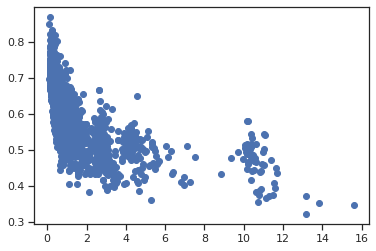

In [83]:
plt.scatter(mses, ssims)

In [54]:
output.shape

torch.Size([64, 2])

In [55]:
t = nn.CrossEntropyLoss()

In [56]:
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)


In [57]:
input.shape

torch.Size([3, 5])

In [58]:
target


tensor([4, 4, 1])

In [59]:
G_loss

tensor(1.3864, device='cuda:1', grad_fn=<DivBackward1>)

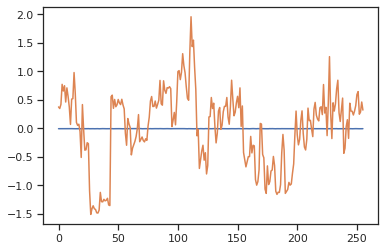

In [60]:
b = 20
i = 3
plt.plot(fake[b, :, i].cpu().data.numpy())
plt.plot(real_data.transpose(1, 2)[b, :, i].cpu().data.numpy())

In [61]:
fake.transpose(1, 2).shape

torch.Size([64, 5, 256])

In [62]:
output.shape

torch.Size([])

In [171]:
G_loss

tensor(1.4090, device='cuda:1', grad_fn=<DivBackward1>)

In [172]:
fake.shape

torch.Size([64, 256, 5])

In [173]:
real_data.transpose(1, 2).shape

torch.Size([64, 256, 5])

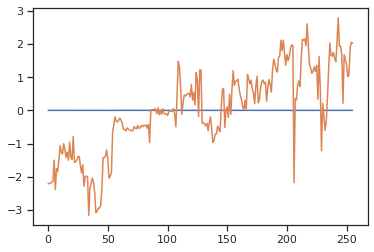

In [174]:
b = 20
i = 3
plt.plot(fake[b, :, i].cpu().data.numpy())
plt.plot(real_data.transpose(1, 2)[b, :, i].cpu().data.numpy())

In [175]:
label = torch.ones(batch_size).to(device)
loss_verif = criterion_verification(embeding_real, embeding_fake, label)

In [176]:
label

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:1')

In [177]:
loss_verif

tensor(0.1495, device='cuda:1', grad_fn=<MeanBackward0>)

In [178]:
loss_verif.item()

0.1494835466146469

In [179]:
margin = 2
output1, output2 = embeding_real, embeding_fake

In [154]:
euclidean_distance = F.pairwise_distance(output1, output2)
pos = (1-label) * torch.pow(euclidean_distance, 2)
neg = (label) * torch.pow(torch.clamp(margin - euclidean_distance, min=0.0), 2)
loss_contrastive = torch.mean( pos + neg )

In [155]:
pos

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:1', grad_fn=<MulBackward0>)

In [156]:
neg

tensor([0.3597, 0.0000, 0.0550, 0.0000, 0.0000, 2.3095, 2.0364, 0.0000, 0.0723,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1411, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0140, 0.1455, 0.1240,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2898, 0.0000,
        0.1607, 0.5297, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.8951, 0.0000, 0.0000, 0.0000, 0.0000, 0.1396, 0.0000, 0.0000,
        0.0000], device='cuda:1', grad_fn=<MulBackward0>)

In [157]:
euclidean_distance

tensor([1.4003, 2.9443, 1.7655, 3.4775, 6.2714, 0.4803, 0.5730, 3.6303, 1.7310,
        2.6732, 3.7965, 2.5309, 2.4604, 2.3462, 2.0150, 2.8192, 3.9881, 3.4901,
        3.4803, 1.6243, 3.6251, 3.4830, 2.6402, 4.0975, 4.0916, 3.1848, 4.1496,
        4.3641, 3.4192, 2.7618, 3.8831, 2.7887, 2.2873, 1.8818, 1.6186, 1.6479,
        2.7391, 2.8767, 2.1301, 5.1027, 2.6711, 5.5629, 2.1864, 1.4617, 3.1660,
        1.5991, 1.2722, 2.3206, 2.2249, 2.5159, 2.8916, 2.2000, 6.7377, 2.2459,
        5.5926, 1.0539, 5.5055, 2.5993, 3.7690, 2.3212, 1.6264, 3.7566, 2.3092,
        3.7522], device='cuda:1', grad_fn=<NormBackward1>)

In [158]:
torch.clamp(margin - euclidean_distance, min=0.0)

tensor([0.5997, 0.0000, 0.2345, 0.0000, 0.0000, 1.5197, 1.4270, 0.0000, 0.2690,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.3757, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1182, 0.3814, 0.3521,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5383, 0.0000,
        0.4009, 0.7278, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.9461, 0.0000, 0.0000, 0.0000, 0.0000, 0.3736, 0.0000, 0.0000,
        0.0000], device='cuda:1', grad_fn=<ClampBackward1>)

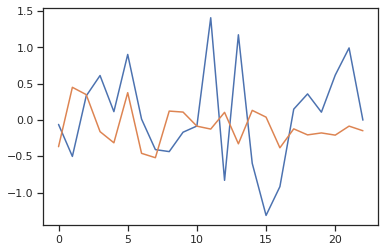

In [159]:
plt.plot(embeding_fake[b].cpu().data.numpy())
plt.plot(embeding_real[b].cpu().data.numpy())

In [160]:
real_data[0]

tensor([[-0.3104, -0.3079, -0.3055,  ...,  0.3055,  0.3079,  0.3104],
        [-0.8622, -0.6736, -0.4765,  ..., -0.4129, -0.4134, -0.4134],
        [-0.1672, -0.0182, -0.0192,  ...,  0.2044, -2.1039, -2.0314],
        [-0.5379, -0.7380, -0.7345,  ...,  0.2521,  0.2487,  0.2107],
        [-0.0384, -0.0158, -0.0185,  ...,  0.0697,  0.0962,  0.0890]],
       device='cuda:1')

In [161]:
embeding_real[0]

tensor([-0.1200, -0.2679,  0.1484,  0.3328, -0.1683,  0.7190,  0.0341, -0.3325,
        -0.0788, -0.0757, -0.1190,  0.7915, -0.6090,  0.5729, -0.1972, -0.7700,
        -0.6346,  0.2301,  0.3337,  0.1058,  0.3786,  0.6399,  0.1494],
       device='cuda:1', grad_fn=<SelectBackward0>)

In [1]:
embeding_fake[0]

NameError: name 'embeding_fake' is not defined

In [88]:
for idx, data_all in enumerate(train_loader):
    # data preprocessing

    real_data, y = data_all
    break

In [ ]:
# TODO добавить skip connections для автоэнкодера? 
# добавить регуляризацию через дискриминатор латентного пространства автоэнкрдера (адверсальный автоэнкодер) 

In [172]:
def train(loader, 
          gen, 
          disc, 
          criterion_gan, 
          G_opt, 
          D_opt, 
          model_verification, 
          criterion_verification, 
          criterion_regulator, 
          save_PATH, 
          lr, batch_size, num_epochs, n_noise, n_critic,
          d_rate=10,
          g_rate=1,
          replay_proba=0.5,
          exp_lim=100000):
    
    try:
        
        #de_ident_rate_list = []
        simil_index = 0

        G_losses = []
        G_all_losses = []
        D_losses = []
        R_losses = []
        V_losses = []
        V_losses2 = []
        verificator_labels = []
        verificator_preds = []

        torch.cuda.empty_cache()
        step = 0
        experience_fake = []
        for epoch in range(num_epochs):
            for idx, data_all in enumerate(loader):
                # data preprocessing
                
                real_data, y = data_all
                real_data, y = real_data.to(device), y.to(device)
                batch_size = real_data.size(0)

                # DISCRIMINATOR TRAINING == maximize D(real_data) + (1 - D(G(noise)))
                if d_rate > 0 and step % d_rate == 0:
                
                    gen.eval()
                    disc.train()
                    D_opt.zero_grad()

                    fake = gen(real_data.transpose(1, 2))
                    
                    # experience replay
                    if np.random.rand() < replay_proba and len(experience_fake) > 0:
                        fake = experience_fake[np.random.randint(len(experience_fake))].to(device)
                    else:
                        efake = fake.cpu().clone().detach()
                        if len(experience_fake) < exp_lim:
                            experience_fake.append(efake)
                        else:
                            experience_fake[np.random.randint(len(experience_fake))] = efake
                    
                    
                    disc_real = disc(real_data)        
                    D_loss_1 = criterion_gan(disc_real, torch.ones(disc_real.shape[0]).long().to(device))
                    disc_fake = disc(fake.transpose(1, 2))
                    D_loss_2 = criterion_gan(disc_fake, torch.zeros(disc_fake.shape[0]).long().to(device))

        #             # verificator loss
        #             model_verification.eval()
        #             embeding_fake = model_verification(fake.transpose(1, 2))
        #             embeding_real = model_verification(real_data)
        #             label = torch.ones(batch_size).to(device)
        #             loss_verif = criterion_verification(embeding_real, embeding_fake, label)
        #             if idx == 82:
        #                 print(f"Epoch [{epoch}] Idx {idx} loss_verif: {loss_verif.item():.4f}")
        #                 #print('embeding_real', embeding_real)
        #                 #print('embeding_fake', embeding_fake)
        #             V_losses.append(loss_verif.item())

        #             # de-identification rate
        #             pred_equal_y = torch.tensor([embeding_fake[i, y[i] - 1].item() for i in range(len(y))]).to(device)
        #             pred_max = torch.max(embeding_fake, dim = 1)[0]
        #             de_ident_rate_list.append((pred_equal_y < pred_max).float().mean())

        #             # similarity loss
        #             if criterion_regulator != Eucledian_distance_loss:
        #                 loss_regul = criterion_regulator()(real_data, fake.transpose(1, 2))
        #             else:
        #                 loss_regul = criterion_regulator()(real_data, fake.transpose(1, 2)) / 1000
        #             R_losses.append(loss_regul.item())

                    D_loss = (D_loss_1 + D_loss_2) / 2 #+ loss_verif.detach() + loss_regul.detach()
                    D_losses.append(D_loss.item())
                    D_loss.backward() # retain_graph = True
                    D_opt.step()
                    #D_loss =  torch.zeros(1)

                    
                    
                    
                #----------------------------------------------------------------------------------------   
                # GENERATOR TRAINING == maximize D(G(noise))
                
                if g_rate > 0 and step % g_rate == 0:
                    
                    gen.train()
                    disc.eval()
                    G_opt.zero_grad()

                    fake = gen(real_data.transpose(1, 2))
                    output = disc(fake.transpose(1, 2))
                    G_loss, MSE, CE, L1, ssim = gan_loss_function(real_data, fake.transpose(1, 2), 
                                               torch.ones(output.shape[0]).long().to(device), output,
                                               )
                    # G_loss = criterion_gan(output, torch.ones_like(output))
                    G_losses.append(G_loss.item())
                    G_all_losses.append((MSE.item(), CE.item(), L1.item(), ssim.item()))
                    G_loss.backward() 
                    G_opt.step()
                    #G_loss =  torch.zeros(1)
                    
                    
                step += 1

            #if epoch % 3 == 0:
            #print(f"Epoch [{epoch}/{num_epochs}] Batch {idx}/{len(loader)} Loss D: {D_loss.item():.4f}, Loss G: {G_loss.item():.4f}, Loss V: {loss_verif.item():.4f}, Loss R: {loss_regul.item():.4f}")
            w = 20
            D_losses_last = np.mean(D_losses) if len(D_losses) < w else np.mean(D_losses[-w:])
            w = 200
            G_losses_last = np.mean(G_losses) if len(G_losses) < w else np.mean(G_losses[-w:])
            
            print(f"Epoch [{epoch}/{num_epochs}]: Loss D: {D_losses_last:.4f}, Loss G: {G_losses_last:.4f}")
            print()

            

    #     de_ident_rate = (sum(de_ident_rate_list) / len(de_ident_rate_list)).item()
    #     str_simil = 1 - sum(R_losses) / len(R_losses)

        
    except KeyboardInterrupt:
        pass
    
    torch.save({
            'gen_state_dict': gen.state_dict(),
            'disc_state_dict': disc.state_dict(),
            'de_ident_rate': None,
            'str_simil': None,
        }, save_PATH)
    
    return G_losses, D_losses, R_losses, V_losses, V_losses2, G_all_losses

In [221]:
losses_ae = train(loader = train_loader, 
                  gen = model_ae, 
                  disc = disc_ae, 
                  criterion_gan = criterion_ae, 
                  G_opt = G_opt_ae, 
                  D_opt = D_opt_ae, 
                  model_verification = model_verification, 
                  criterion_verification = criterion_verification, 
                  criterion_regulator = Mean_similarity_loss,
                  save_PATH = 'trained_models/gan_ae.pt', 
                  lr = lr, 
                  batch_size = batch_size, 
                  num_epochs = 1000,#num_epochs, 
                  n_noise = n_noise, 
                  n_critic = n_critic,
                  d_rate=1,
                  g_rate=1)

Epoch [0/1000]: Loss D: 0.3650, Loss G: 7.8280

Epoch [1/1000]: Loss D: 0.4455, Loss G: 9.2692

Epoch [2/1000]: Loss D: 2.1770, Loss G: 10.6831

Epoch [3/1000]: Loss D: 0.4842, Loss G: 7.0024

Epoch [4/1000]: Loss D: 0.3133, Loss G: 5.5386

Epoch [5/1000]: Loss D: 0.4396, Loss G: 3.3927

Epoch [6/1000]: Loss D: 0.2432, Loss G: 4.9776

Epoch [7/1000]: Loss D: 0.2117, Loss G: 5.1274

Epoch [8/1000]: Loss D: 0.3562, Loss G: 3.3849

Epoch [9/1000]: Loss D: 0.1494, Loss G: 3.2432

Epoch [10/1000]: Loss D: 0.4955, Loss G: 2.4642

Epoch [11/1000]: Loss D: 0.3409, Loss G: 8.1496

Epoch [12/1000]: Loss D: 0.4885, Loss G: 8.8812

Epoch [13/1000]: Loss D: 0.5937, Loss G: 3.9288

Epoch [14/1000]: Loss D: 0.4447, Loss G: 3.3707

Epoch [15/1000]: Loss D: 0.8404, Loss G: 3.4867

Epoch [16/1000]: Loss D: 0.6025, Loss G: 3.3682

Epoch [17/1000]: Loss D: 0.1635, Loss G: 2.6854

Epoch [18/1000]: Loss D: 0.2901, Loss G: 1.5318

Epoch [19/1000]: Loss D: 0.1963, Loss G: 1.1122

Epoch [20/1000]: Loss D: 0.29

Epoch [167/1000]: Loss D: 0.2129, Loss G: 1.9592

Epoch [168/1000]: Loss D: 0.1598, Loss G: 2.1420

Epoch [169/1000]: Loss D: 0.3348, Loss G: 2.5386

Epoch [170/1000]: Loss D: 0.1591, Loss G: 2.2718

Epoch [171/1000]: Loss D: 0.1715, Loss G: 2.0263

Epoch [172/1000]: Loss D: 0.1149, Loss G: 1.9606

Epoch [173/1000]: Loss D: 0.5943, Loss G: 2.8442

Epoch [174/1000]: Loss D: 0.0789, Loss G: 3.6028

Epoch [175/1000]: Loss D: 0.1634, Loss G: 4.1051

Epoch [176/1000]: Loss D: 0.2312, Loss G: 4.8331

Epoch [177/1000]: Loss D: 0.1048, Loss G: 4.1791

Epoch [178/1000]: Loss D: 0.6842, Loss G: 2.8625

Epoch [179/1000]: Loss D: 0.2603, Loss G: 1.8933

Epoch [180/1000]: Loss D: 0.1427, Loss G: 1.9588

Epoch [181/1000]: Loss D: 0.2800, Loss G: 2.2917

Epoch [182/1000]: Loss D: 0.1295, Loss G: 2.6266

Epoch [183/1000]: Loss D: 0.1641, Loss G: 3.2295

Epoch [184/1000]: Loss D: 0.1690, Loss G: 3.0257

Epoch [185/1000]: Loss D: 0.1546, Loss G: 2.3656

Epoch [186/1000]: Loss D: 0.1999, Loss G: 2.0360



In [222]:
import pandas as pd

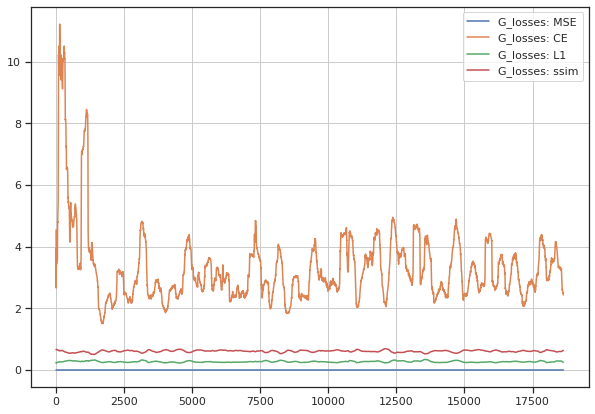

In [223]:
plt.figure(figsize=(10, 7))

max_len = np.max([len(losses_ae[0]), len(losses_ae[1])])

plt.plot(np.linspace(0, max_len, len(losses_ae[0])), 
         pd.Series([x[0] for x in losses_ae[-1]]).rolling(window=250, min_periods=0).mean().values, label = 'G_losses: MSE')
plt.plot(np.linspace(0, max_len, len(losses_ae[0])), 
         pd.Series([x[1] for x in losses_ae[-1]]).rolling(window=250, min_periods=0).mean().values, label = 'G_losses: CE')
plt.plot(np.linspace(0, max_len, len(losses_ae[0])), 
         pd.Series([x[2] for x in losses_ae[-1]]).rolling(window=250, min_periods=0).mean().values, label = 'G_losses: L1')
plt.plot(np.linspace(0, max_len, len(losses_ae[0])), 
         pd.Series([x[3] for x in losses_ae[-1]]).rolling(window=250, min_periods=0).mean().values, label = 'G_losses: ssim')

#plt.plot(pd.Series(losses_ae[2]).rolling(window=250).mean().values, label = 'R_losses')
#plt.plot(pd.Series(losses_ae[3]).rolling(window=250).mean().values, label = 'V_losses')
plt.legend()
plt.grid()
plt.show()

Text(0, 0.5, 'CE')

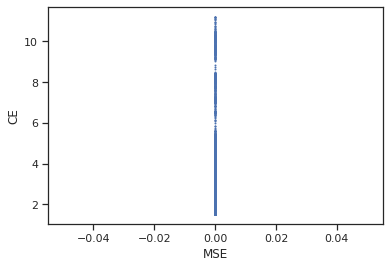

In [224]:
plt.scatter(pd.Series([x[0] for x in losses_ae[-1]]).rolling(window=250, min_periods=0).mean().values,
            pd.Series([x[1] for x in losses_ae[-1]]).rolling(window=250, min_periods=0).mean().values,
            s=1)
plt.xlabel('MSE')
plt.ylabel('CE')

Text(0, 0.5, 'CE')

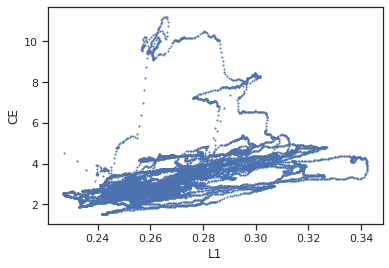

In [225]:
plt.scatter(pd.Series([x[2] for x in losses_ae[-1]]).rolling(window=250, min_periods=0).mean().values,
            pd.Series([x[1] for x in losses_ae[-1]]).rolling(window=250, min_periods=0).mean().values,
            s=1)
plt.xlabel('L1')
plt.ylabel('CE')

Text(0, 0.5, 'ssim')

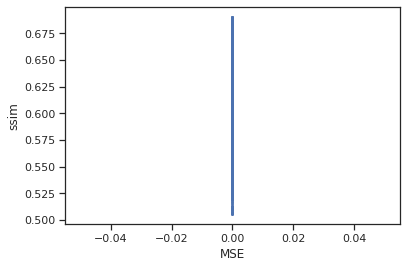

In [226]:
plt.scatter(pd.Series([x[0] for x in losses_ae[-1]]).rolling(window=250, min_periods=0).mean().values,
            pd.Series([x[3] for x in losses_ae[-1]]).rolling(window=250, min_periods=0).mean().values,
            s=1)
plt.xlabel('MSE')
plt.ylabel('ssim')

Text(0, 0.5, 'CE')

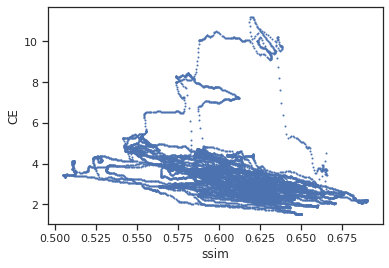

In [227]:
plt.scatter(pd.Series([x[3] for x in losses_ae[-1]]).rolling(window=250, min_periods=0).mean().values,
            pd.Series([x[1] for x in losses_ae[-1]]).rolling(window=250, min_periods=0).mean().values,
            s=1)
plt.xlabel('ssim')
plt.ylabel('CE')

In [228]:
CE_baseline = []
for idx, data_all in enumerate(loader):
    # data preprocessing

    real_data, y = data_all
    real_data, y = real_data.to(device), y.to(device)
    batch_size = real_data.size(0)

    gen.eval()
    disc.eval()
    G_opt.zero_grad()

    fake = gen(real_data.transpose(1, 2))
    #output = disc(fake.transpose(1, 2))
    output = disc(real_data)
    G_loss, MSE, CE, L1, ssim = gan_loss_function(real_data, fake.transpose(1, 2), 
                               torch.ones(output.shape[0]).long().to(device), output,
                               )

    CE_baseline.append(CE.item())



    

In [229]:
np.mean(CE_baseline)

0.5135856683713844

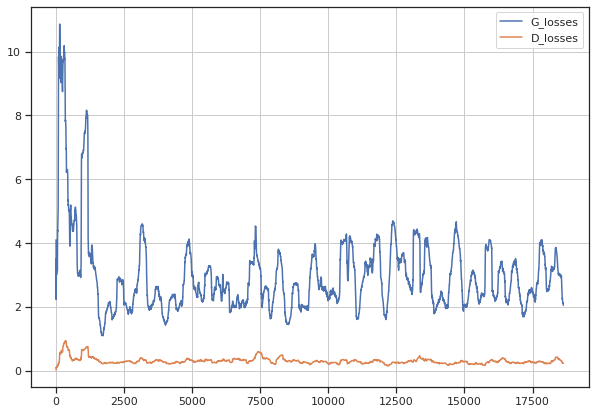

In [230]:
plt.figure(figsize=(10, 7))

max_len = np.max([len(losses_ae[0]), len(losses_ae[1])])

plt.plot(np.linspace(0, max_len, len(losses_ae[0])), 
         pd.Series(losses_ae[0]).rolling(window=250, min_periods=0).mean().values, label = 'G_losses')
plt.plot(np.linspace(0, max_len, len(losses_ae[1])), 
         pd.Series(losses_ae[1]).ffill().rolling(window=250, min_periods=0).mean().values, label = 'D_losses')
#plt.plot(pd.Series(losses_ae[2]).rolling(window=250).mean().values, label = 'R_losses')
#plt.plot(pd.Series(losses_ae[3]).rolling(window=250).mean().values, label = 'V_losses')
plt.legend()
plt.grid()
plt.show()

In [207]:
# model_ae = AutoEncoder(in_channels=len(required_params), 
#                        conv1_channels=50, 
#                        conv2_channels=100, 
#                        interm_lsz=1000, 
#                        pre_hidden_sz=200, 
#                        hidden_lsz=latent_dim).to(device)
# disc_ae = DiscriminatorNoPatch().to(device)

# checkpoint_ae = torch.load('trained_models/gan_ae.pt')

# model_ae.load_state_dict(checkpoint_ae['gen_state_dict'])
# disc_ae.load_state_dict(checkpoint_ae['disc_state_dict'])
# de_ident_rate_ae = checkpoint_ae['de_ident_rate']
# str_simil_ae = checkpoint_ae['str_simil']
# print(de_ident_rate_ae)
# print(str_simil_ae)
# # gen_ms.eval()

## test

In [208]:
scales_vectors = np.array([torch_dataset.feature_scales[f] for f in range(len(required_params))])

sparse_rate = torch_dataset.sparse_rate
print('sparse_rate', sparse_rate)
L = 64
print('L', L)
# window = L * sparse_rate
window = 256
print('window', window)
step = 4
print('step', step)

sparse_rate 1
L 64
window 256
step 4


In [209]:
test_well = wells[22]
test_well

'well_17.json'

In [210]:
X_test = pd.DataFrame(logs[22]['data'], columns=[x['name'] for x in logs[22]['curves']])
X_test = X_test[required_params]
X_test = X_test.drop_duplicates()

In [211]:
y_name = 'DEPTH'


In [212]:
def apply_window_transform(x, s, latent_noise_rate=0):
    x = x[np.arange(0, len(x), sparse_rate), :]
    mean_x = x.mean(axis=0)
    x = (x - mean_x)/s
    with torch.no_grad():
        x = torch.Tensor(x).view(1, x.shape[0], -1).to(device)
        z = model_ae(x)
    
    return z[0].cpu().data.numpy()*s + mean_x, z[0].cpu().data.numpy()

In [213]:
def apply_rolling_transform(X, w, scales, step=12):
    Z = []
    
    for i in tqdm(range(0, len(X) - w, step)):
        Z.append(apply_window_transform(X[i: i+w], scales))
        
    return Z

In [214]:
Z = apply_rolling_transform(X_test[required_params].values, window, scales_vectors, step)


100%|████████████████████████████████████████████████████████████| 789/789 [00:01<00:00, 554.47it/s]


In [215]:
offset = 1000
x = X_test[required_params].values[offset: offset + window]

In [216]:
z = apply_window_transform(x, scales_vectors)[0]

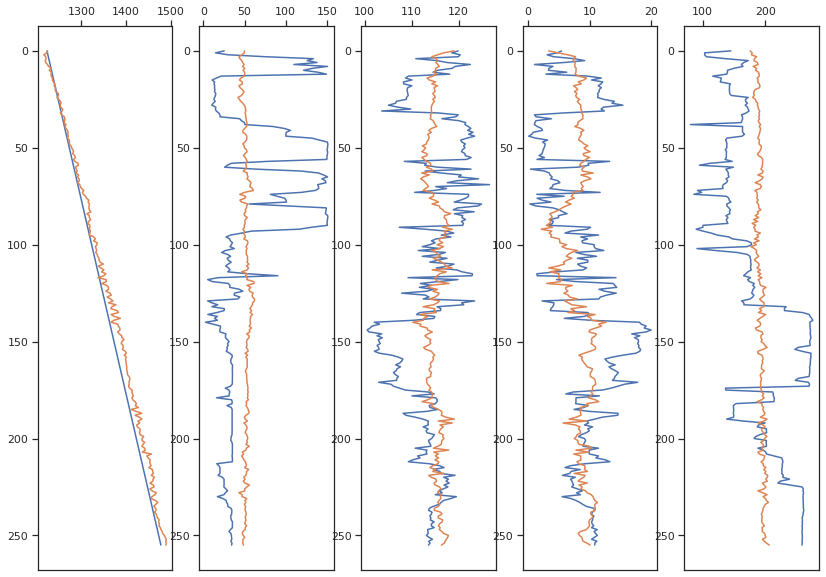

In [217]:
plt.figure(figsize=(14, 10))
for i in range(x.shape[1]):
    plt.subplot(1, x.shape[1], i + 1)
    plt.plot(x[:, i], np.arange(len(x)))
    plt.plot(z[:, i], np.arange(len(z)))
    axis = plt.gca()
    axis.invert_yaxis()
    axis.xaxis.tick_top()

In [218]:
offset = 2000
x = X_test[required_params].values[offset: offset + window]

In [219]:
z = apply_window_transform(x, scales_vectors)[0]

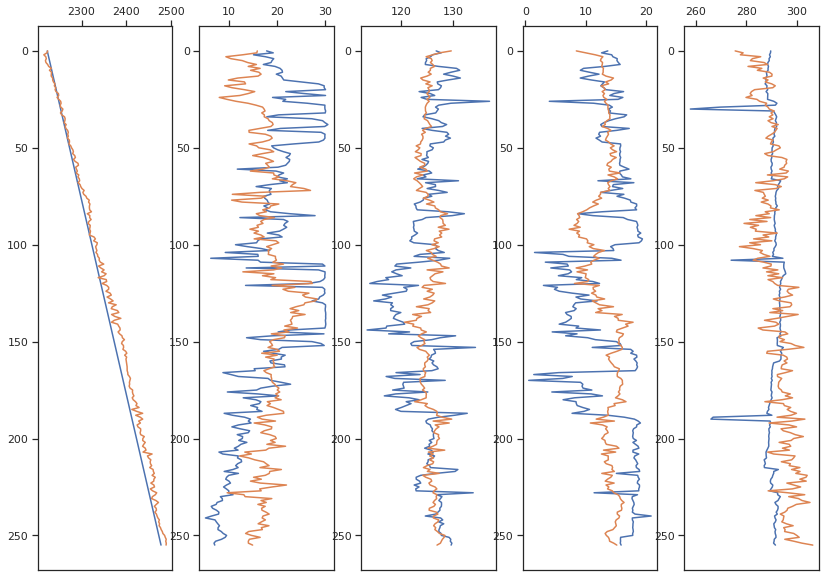

In [220]:
plt.figure(figsize=(14, 10))
for i in range(x.shape[1]):
    plt.subplot(1, x.shape[1], i + 1)
    plt.plot(x[:, i], np.arange(len(x)))
    plt.plot(z[:, i], np.arange(len(z)))
    axis = plt.gca()
    axis.invert_yaxis()
    axis.xaxis.tick_top()

789it [00:00, 169092.32it/s]
/home/n_klyuchnikov/miniconda3/envs/dpgan/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
789it [00:00, 141786.88it/s]
/home/n_klyuchnikov/miniconda3/envs/dpgan/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
789it [00:00, 153621.11it/s]
/home/n_klyuchnikov/miniconda3/envs/dpgan/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
789it [00:00, 178639.99it/s]
/home/n_klyuchnikov/miniconda3/envs/dpgan/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
789it [00:00, 183952.52it/s]
/home/n_klyuchnikov/miniconda3/envs/dpgan/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


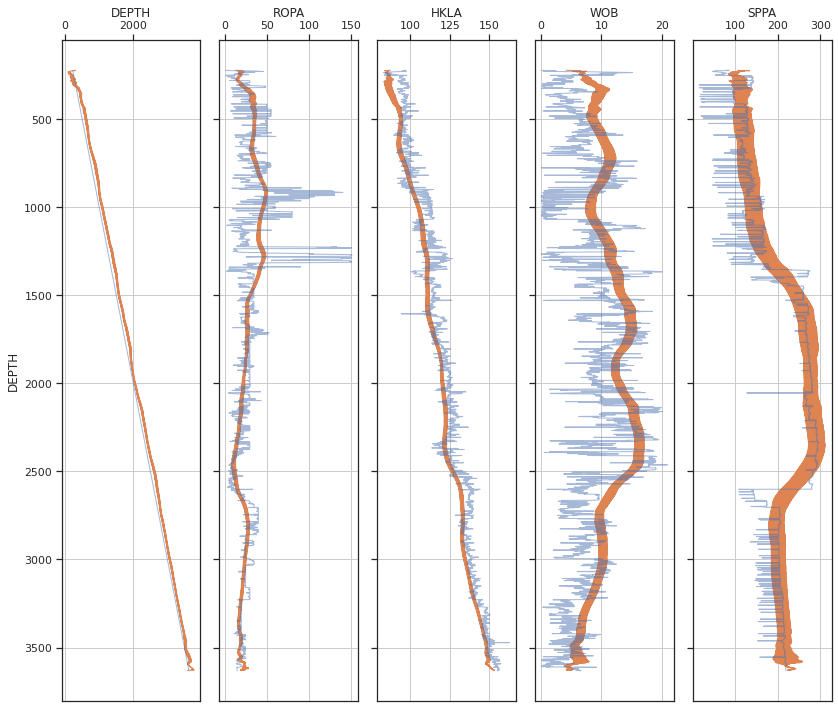

In [171]:
original = []
generated = []

t = X_test[y_name].astype(float).values
plt.figure(figsize=(14, 10))
for i, curve_name in enumerate(required_params):
    plt.subplot(1, len(df.columns) - 1, i + 1)

    zis = range(0, len(X_test) - window, step)
    A = np.zeros((len(zis), len(X_test))) * np.nan
    for zi, x in tqdm(enumerate(zis)):
        A[zi, np.arange(x, x+window, sparse_rate)] = Z[zi][0][:, i]
    
    A = np.nanmean(A, axis=0)
    not_nan_inds = np.where(~np.isnan(A))[0]
    
#     original.append(X_test[curve_name].astype(float).values)
#     generated.append(A[not_nan_inds])
    
    plt.plot(A[not_nan_inds], t[not_nan_inds], color='C1', lw=1)
    plt.plot(X_test[curve_name].astype(float).values, t, lw=1, color='C0', alpha=0.5)
    plt.grid()
    axis = plt.gca()
    axis.invert_yaxis()
    axis.xaxis.tick_top()
    axis.xaxis.set_label_position('top')
    if i > 0: axis.set_yticklabels([])

    if i == 0:
        plt.ylabel(f'{y_name}')
    plt.xlabel(f'{curve_name}')

plt.tight_layout()
# plt.savefig('images/CBA.png')

789it [00:00, 154814.08it/s]
/home/n_klyuchnikov/miniconda3/envs/dpgan/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
789it [00:00, 153038.56it/s]
/home/n_klyuchnikov/miniconda3/envs/dpgan/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
789it [00:00, 149742.35it/s]
/home/n_klyuchnikov/miniconda3/envs/dpgan/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
789it [00:00, 145624.02it/s]
/home/n_klyuchnikov/miniconda3/envs/dpgan/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
789it [00:00, 150958.21it/s]
/home/n_klyuchnikov/miniconda3/envs/dpgan/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


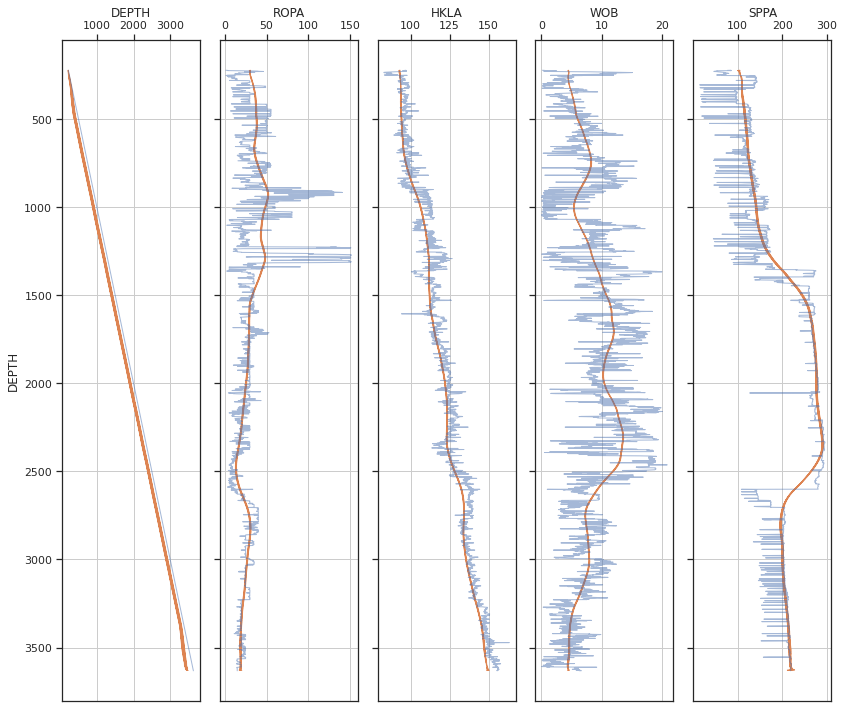

In [53]:
original = []
generated = []

t = X_test[y_name].astype(float).values
plt.figure(figsize=(14, 10))
for i, curve_name in enumerate(required_params):
    plt.subplot(1, len(df.columns) - 1, i + 1)

    zis = range(0, len(X_test) - window, step)
    A = np.zeros((len(zis), len(X_test))) * np.nan
    for zi, x in tqdm(enumerate(zis)):
        A[zi, np.arange(x, x+window, sparse_rate)] = Z[zi][0][:, i]
    
    A = np.nanmean(A, axis=0)
    not_nan_inds = np.where(~np.isnan(A))[0]
    
#     original.append(X_test[curve_name].astype(float).values)
#     generated.append(A[not_nan_inds])
    
    plt.plot(A[not_nan_inds], t[not_nan_inds], color='C1', lw=1)
    plt.plot(X_test[curve_name].astype(float).values, t, lw=1, color='C0', alpha=0.5)
    plt.grid()
    axis = plt.gca()
    axis.invert_yaxis()
    axis.xaxis.tick_top()
    axis.xaxis.set_label_position('top')
    if i > 0: axis.set_yticklabels([])

    if i == 0:
        plt.ylabel(f'{y_name}')
    plt.xlabel(f'{curve_name}')

plt.tight_layout()
# plt.savefig('images/CBA.png')

In [42]:
# for i in required_params[:-1]:
#     sns.displot(data=df_some, 
#             x=i, hue='WELL', kind='kde',
#             fill=True, palette=sns.color_palette('bright')[:2], height=5, aspect=1.5
#                )